C:\Users\bhumu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bhumu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bhumu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bhumu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

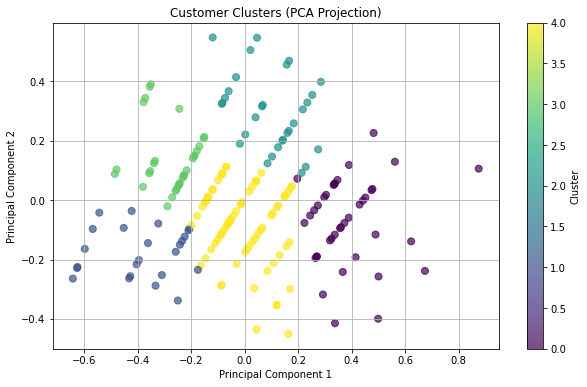

Optimal Number of Clusters: 5
Davies-Bouldin Index for Optimal Clustering: 0.81852655328168
Cluster Profiles:
   Cluster  AvgTotalSpending  AvgTransactionValue  AvgTransactionFrequency  \
0        0       6056.023846           756.631630                 8.102564   
1        1       1030.337500           328.694389                 2.916667   
2        2       4436.344000          1049.721544                 4.300000   
3        3       1725.070333           733.971667                 2.400000   
4        4       3213.685526           604.215276                 5.434211   

   CustomerCount  
0             39  
1             24  
2             30  
3             30  
4             76  


In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load datasets
customers_df = pd.read_csv(r"C:\Users\bhumu\Downloads\Customers.csv")
transactions_df = pd.read_csv(r"C:\Users\bhumu\Downloads\Transactions.csv")

# Merge datasets on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")

# Create aggregated features for each customer
customer_features = merged_df.groupby("CustomerID").agg(
    TotalSpending=("TotalValue", "sum"),
    AvgTransactionValue=("TotalValue", "mean"),
    TransactionFrequency=("TransactionID", "count")
).reset_index()

# Merge aggregated features back with customer profile data
customer_profile = pd.merge(customer_features, customers_df, on="CustomerID", how="inner")

# Select features for clustering
features = customer_profile[["TotalSpending", "AvgTransactionValue", "TransactionFrequency"]]

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Test different numbers of clusters and calculate DB Index for each
db_index_scores = []
silhouette_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, clusters)
    silhouette_avg = silhouette_score(scaled_features, clusters)
    db_index_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

# Optimal number of clusters
optimal_clusters = cluster_range[db_index_scores.index(min(db_index_scores))]

# Perform clustering with the optimal number of clusters (8)
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_clusters = final_kmeans.fit_predict(scaled_features)

# Add final cluster labels to the dataset
customer_profile["Cluster"] = final_clusters

# Cluster profiling
cluster_profiles = customer_profile.groupby("Cluster").agg(
    AvgTotalSpending=("TotalSpending", "mean"),
    AvgTransactionValue=("AvgTransactionValue", "mean"),
    AvgTransactionFrequency=("TransactionFrequency", "mean"),
    CustomerCount=("CustomerID", "count")
).reset_index()

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_features[:, 0], pca_features[:, 1], c=final_clusters, cmap="viridis", s=50, alpha=0.7
)
plt.colorbar(scatter, label="Cluster")
plt.title("Customer Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Output key results
print("Optimal Number of Clusters:", optimal_clusters)
print("Davies-Bouldin Index for Optimal Clustering:", min(db_index_scores))
print("Cluster Profiles:")
print(cluster_profiles)
